# Benchmark de inferencia (RF-DETR)

Este notebook calcula tiempos de inferencia por imagen sobre un conjunto de ejemplo y resume media, mediana y percentil 95.


## Flujo

1. Configurar rutas del checkpoint y del directorio con imágenes.
2. Cargar el modelo RF-DETR y crear un `SimpleStitcher` con ventana de 560 px.
3. Medir tiempos sobre hasta 100 imágenes (con warmup opcional) sincronizando el dispositivo.
4. Mostrar distribución (tabla + métricas resumen).


In [1]:
from __future__ import annotations

import math
import statistics
import sys
import time
from pathlib import Path
from typing import Dict, List

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from PIL import Image
from albumentations.pytorch import ToTensorV2


REPO_ROOT = Path.cwd()

# ---------------------------------------------------------------------------
# Parámetros a ajustar
# ---------------------------------------------------------------------------

CHECKPOINT_PATH = REPO_ROOT / "outputs/rfdetr_small/checkpoint_512_small_phase2.pth"
IMAGES_DIR = REPO_ROOT / "data-delplanque" / "test"  # Directorio de imágenes
MAX_IMAGES = 100
WARMUP_IMAGES = 5
PATCH_SIZE = 512
PATCH_OVERLAP = 0
BATCH_SIZE = 32
CONFIDENCE_THRESHOLD = 0.5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)

print(f"Dispositivo: {DEVICE}")


INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.8). Upgrade using: pip install --upgrade albumentations


Dispositivo: cuda


### Cargar modelo y stitcher

In [2]:
from rfdetr import RFDETRSmall

from utils.rf_detr import SimpleStitcher

checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
state_dict = checkpoint.get('model', checkpoint.get('ema_model'))
num_classes = state_dict['class_embed.weight'].shape[0]

model_eval = RFDETRSmall()
model_eval.model.reinitialize_detection_head(num_classes)
model_eval.model.model.load_state_dict(state_dict, strict=True)
model_eval.model.model.to(DEVICE).eval()

stitcher = SimpleStitcher(
    model=model_eval.model.model,
    patch_size=PATCH_SIZE,
    overlap=PATCH_OVERLAP,
    batch_size=BATCH_SIZE,
    confidence_threshold=CONFIDENCE_THRESHOLD,
    device=DEVICE,
    label_offset=0,
)

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


### Selección de imágenes


In [3]:
image_paths = sorted([p for p in IMAGES_DIR.iterdir() if p.suffix.lower() in {'.jpg', '.jpeg', '.png'}])
if not image_paths:
    raise RuntimeError(f"No se encontraron imágenes en {IMAGES_DIR}")

selected = image_paths[: min(len(image_paths), MAX_IMAGES + WARMUP_IMAGES)]
print(f"Imágenes totales encontradas: {len(image_paths)}")
print(f"Usaremos {len(selected)} (incluye warmup)")

# Pre-cargar a memoria para evitar medir IO en cada iteración
loaded_images: List[tuple[Path, np.ndarray]] = []
for path in selected:
    arr = np.array(Image.open(path).convert('RGB'))
    loaded_images.append((path, arr))

print('First sample:', loaded_images[0][0])


Imágenes totales encontradas: 258
Usaremos 105 (incluye warmup)
First sample: /mnt/batch/tasks/shared/LS_root/mounts/clusters/asg-lab/code/Users/amir.sadour/proyecto/data-delplanque/test/01802f75da35434ab373569fffc1fd65a3417aef.JPG


### Benchmark

Sincronizamos el dispositivo tras cada inferencia para capturar el tiempo real de finalización.


In [4]:
transform = A.Compose([
    A.Normalize(mean=MEAN, std=STD),
    ToTensorV2(),
])

def to_tensor(image: np.ndarray) -> torch.Tensor:
    return transform(image=image)['image']

@torch.no_grad()
def timed_inference(tensor: torch.Tensor) -> float:
    start = time.perf_counter()
    _ = stitcher(tensor)
    if DEVICE.type == 'cuda':
        torch.cuda.synchronize(DEVICE)
    return time.perf_counter() - start

# Warmup
for path, img in loaded_images[:WARMUP_IMAGES]:
    tensor = to_tensor(img)
    _ = timed_inference(tensor)

records: List[Dict] = []
for path, img in loaded_images[WARMUP_IMAGES:]:
    tensor = to_tensor(img)
    duration = timed_inference(tensor)
    records.append({
        'image': path.name,
        'seconds': duration,
        'milliseconds': duration * 1e3,
    })

results_df = pd.DataFrame(records)
print(f"Inferencias medidas: {len(results_df)}")
results_df.head()


Inferencias medidas: 100


,image,seconds,milliseconds
0,04bda8c273b5ef6b29e1f318a1da3e7506a5e4d8.JPG,0.170163,170.162891
1,04e8092d743bef891386f3e0ce82155f12aa4035.JPG,0.169499,169.498501
2,04f53ca293e5037fc04f61e49b372d8f003c482d.JPG,0.381622,381.621816
3,052dd6b36a90b1d68fc38a6151b43caf7cbc9d43.JPG,0.230751,230.750837
4,05964db76e32bf325ee31238c27cfadab43cabaa.JPG,0.166695,166.695372


### Métricas resumen


In [5]:
if results_df.empty:
    raise RuntimeError('No se midieron inferencias. Revisa configuración.')

mean_ms = results_df['milliseconds'].mean()
median_ms = results_df['milliseconds'].median()
p95_ms = results_df['milliseconds'].quantile(0.95)
std_ms = results_df['milliseconds'].std(ddof=1) if len(results_df) > 1 else float('nan')

print(f"Media:   {mean_ms:.2f} ms")
print(f"Mediana: {median_ms:.2f} ms")
print(f"p95:     {p95_ms:.2f} ms")
print(f"Std:     {std_ms:.2f} ms")


Media:   193.39 ms
Mediana: 171.49 ms
p95:     352.77 ms
Std:     55.41 ms


### Distribución de tiempos


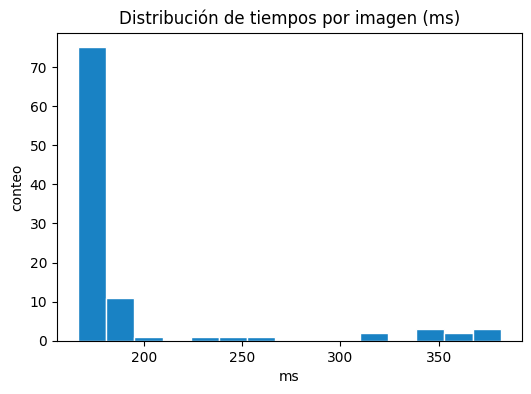

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(results_df['milliseconds'], bins=15, color='#1982c4', edgecolor='white')
ax.set_title('Distribución de tiempos por imagen (ms)')
ax.set_xlabel('ms')
ax.set_ylabel('conteo')
plt.show()


### Guardar resultados


In [9]:
OUTPUT_CSV = REPO_ROOT / 'experiments' / 'inference_rf_detr_small.csv'
results_df.to_csv(OUTPUT_CSV, index=False)
print(f"Resultados guardados en {OUTPUT_CSV}")

Resultados guardados en /mnt/batch/tasks/shared/LS_root/mounts/clusters/asg-lab/code/Users/amir.sadour/proyecto/experiments/inference_rf_detr_small.csv


## HERDNET

In [11]:
from animaloc.models import HerdNet, LossWrapper, load_model
from animaloc.eval import HerdNetStitcher

In [12]:
DEFAULT_CLASSES = {
        1: "Hartebeest",
        2: "Buffalo",
        3: "Kob",
        4: "Warthog",
        5: "Waterbuck",
        6: "Elephant",
    }

In [16]:
CHECKPOINT_PATH = REPO_ROOT / "outputs/herdnet/best_model_stage_2.pth"
IMAGES_DIR = REPO_ROOT / "data-delplanque" / "test"  # Directorio de imágenes
MAX_IMAGES = 100
WARMUP_IMAGES = 5
PATCH_SIZE = 512
PATCH_OVERLAP = 0
BATCH_SIZE = 32
CONFIDENCE_THRESHOLD = 0.5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DOWN_RATIO = 2

MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)

print(f"Dispositivo: {DEVICE}")

Dispositivo: cuda


In [17]:
checkpoint = torch.load(CHECKPOINT_PATH, map_location="cpu")
class_map = checkpoint.get('classes')
if class_map:
    class_map = {int(k): str(v) for k, v in class_map.items()}
else:
    class_map = DEFAULT_CLASSES

num_classes = len(class_map) + 1  # + background
MEAN = tuple(checkpoint.get('mean', MEAN))
STD = tuple(checkpoint.get('std', STD))
down_ratio = checkpoint.get('down_ratio', DOWN_RATIO)

base_model = HerdNet(
    num_classes=num_classes,
    down_ratio=down_ratio,
    num_layers=34,
    head_conv=64,
    pretrained=False,
).to(DEVICE)

model = LossWrapper(base_model, losses=[]).to(DEVICE)
model = load_model(model, pth_path=str(CHECKPOINT_PATH))
model.eval()

stitcher = HerdNetStitcher(
    model=model,
    size=(PATCH_SIZE, PATCH_SIZE),
    overlap=PATCH_OVERLAP,
    down_ratio=down_ratio,
    reduction='mean',
    up=False,
)

print(f"Clases (incl. background): {num_classes}")

Clases (incl. background): 7


In [18]:
transform = A.Compose([
    A.Normalize(mean=MEAN, std=STD),
    ToTensorV2(),
])

def to_tensor(image: np.ndarray) -> torch.Tensor:
    return transform(image=image)['image']

@torch.no_grad()
def timed_inference(tensor: torch.Tensor) -> float:
    start = time.perf_counter()
    _ = stitcher(tensor)
    if DEVICE.type == 'cuda':
        torch.cuda.synchronize(DEVICE)
    return time.perf_counter() - start

# Warmup
for path, img in loaded_images[:WARMUP_IMAGES]:
    tensor = to_tensor(img)
    _ = timed_inference(tensor)

records: List[Dict] = []
for path, img in loaded_images[WARMUP_IMAGES:]:
    tensor = to_tensor(img)
    duration = timed_inference(tensor)
    records.append({
        'image': path.name,
        'seconds': duration,
        'milliseconds': duration * 1e3,
    })

results_df = pd.DataFrame(records)
print(f"Inferencias medidas: {len(results_df)}")
results_df.head()


Inferencias medidas: 100


,image,seconds,milliseconds
0,04bda8c273b5ef6b29e1f318a1da3e7506a5e4d8.JPG,0.441156,441.156463
1,04e8092d743bef891386f3e0ce82155f12aa4035.JPG,0.540544,540.544142
2,04f53ca293e5037fc04f61e49b372d8f003c482d.JPG,0.431285,431.285369
3,052dd6b36a90b1d68fc38a6151b43caf7cbc9d43.JPG,0.493922,493.922070
4,05964db76e32bf325ee31238c27cfadab43cabaa.JPG,0.439957,439.956544


### Métricas resumen


In [19]:
if results_df.empty:
    raise RuntimeError('No se midieron inferencias. Revisa configuración.')

mean_ms = results_df['milliseconds'].mean()
median_ms = results_df['milliseconds'].median()
p95_ms = results_df['milliseconds'].quantile(0.95)
std_ms = results_df['milliseconds'].std(ddof=1) if len(results_df) > 1 else float('nan')

print(f"Media:   {mean_ms:.2f} ms")
print(f"Mediana: {median_ms:.2f} ms")
print(f"p95:     {p95_ms:.2f} ms")
print(f"Std:     {std_ms:.2f} ms")


Media:   464.01 ms
Mediana: 441.27 ms
p95:     556.02 ms
Std:     50.10 ms


### Distribución de tiempos


In [22]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(results_df['milliseconds'], bins=15, color='#1982c4', edgecolor='white')
ax.set_title('Distribución de tiempos por imagen (ms)')
ax.set_xlabel('ms')
ax.set_ylabel('conteo')
plt.show()

### Guardar resultados


In [9]:
OUTPUT_CSV = REPO_ROOT / 'experiments' / 'inference_herdnet.csv'
results_df.to_csv(OUTPUT_CSV, index=False)
print(f"Resultados guardados en {OUTPUT_CSV}")

Resultados guardados en /mnt/batch/tasks/shared/LS_root/mounts/clusters/asg-lab/code/Users/amir.sadour/proyecto/experiments/inference_rf_detr_small.csv
